In [31]:
#pip install matplotlib
import os

# Get the current working directory
cwd = os.getcwd()
print(cwd)
os.chdir("/home/kurowskik/data_wb_iad/projekt/DeepCOVIDExplainer")

/home/kurowskik/data_wb_iad/projekt/DeepCOVIDExplainer


In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [33]:
x_train = np.load('../../data/x_train_undersampled.npy')
y_train = np.load('../../data/y_train_undersampled.npy')
x_test = np.load('../../data/x_test_undersampled.npy')
y_test = np.load('../../data/y_test_undersampled.npy')

In [34]:
print(x_train.shape)
print(x_test.shape)

(5010, 224, 224, 3)
(300, 224, 224, 3)


In [35]:
print(y_train.shape)
print(y_test.shape)

(5010,)
(300,)


In [23]:
#x_train /= 255????
import os

# Get the current working directory
print( os.getcwd())

/home/kurowskik/data_wb_iad/projekt/DeepCOVIDExplainer


In [43]:
from __future__ import print_function

import numpy as np
from random import shuffle
import time
import csv
from PIL import Image
import os
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras import initializers
from keras.optimizers import SGD
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential,load_model,Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import *
from keras.callbacks import CSVLogger
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import sklearn.metrics as sklm
from utils import lossprettifier
from Classifier import VGG
from Classifier.VGG import *

In [37]:
# for reproducibility
np.random.seed(3768)

# use this environment flag to change which GPU to use 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

#Get TensorFlow session
def get_session(): 
    config = tf.ConfigProto() 
    config.gpu_options.allow_growth = True
    return tf.Session(config=config) 
  
# One hot encoding of labels 
def dense_to_one_hot(labels_dense,num_clases=4):
    return np.eye(num_clases)[labels_dense]

In [38]:
# Preparing training and test sets
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [39]:
y_train = dense_to_one_hot(y_train,num_clases=4)
y_valid= dense_to_one_hot(y_valid,num_clases=4)

In [40]:
#Image data generation for the training 
datagen = ImageDataGenerator(
               featurewise_center = False, 
               samplewise_center = False,  # set each sample mean to 0
               featurewise_std_normalization = True,  
               samplewise_std_normalization = False)  

datagen.fit(x_train) 
for i in range(len(x_test)):
      x_test[i] = datagen.standardize(x_test[i])

/home/kurowskik/wbiad3.6/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [48]:
from Classifier.VGG_with_l1 import *

#Defining hyperparameters
batch_Size = 32
steps_Per_Epoch = 32
numEpochs = 50

#Instantating VGG19 model
model = VGG19_l1((224,224,3),4) #VGG19_dense for revised VGG19, VGG19 for VGG19. Please pay attention to VGG16(), chnage the input shape and class number in VGG.py.

#Creating an optimizers
adaDelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(optimizer = sgd , loss = 'categorical_crossentropy', metrics = ['accuracy'])

#Creating early stopping 
earlystop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 50, verbose = 1, mode = 'auto', restore_best_weights = True)       

train_generator = datagen.flow(x_train, y_train, batch_size = batch_Size)
validation_generator = datagen.flow(x_valid, y_valid, batch_size = batch_Size)

# Model training
history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_Per_Epoch,
    validation_data = validation_generator, 
    validation_steps = 16,
    epochs = numEpochs,
    shuffle = True, 
    verbose = 1)

Epoch 1/50
32/32 [==============================] - 19s 609ms/step - loss: 1.3611 - acc: 0.3242 - val_loss: 1.3420 - val_acc: 0.3433
Epoch 2/50
32/32 [==============================] - 14s 450ms/step - loss: 1.2225 - acc: 0.4873 - val_loss: 1.1271 - val_acc: 0.6028
Epoch 3/50
32/32 [==============================] - 14s 424ms/step - loss: 1.1075 - acc: 0.5938 - val_loss: 1.0882 - val_acc: 0.6048
Epoch 4/50
32/32 [==============================] - 14s 425ms/step - loss: 1.0685 - acc: 0.6211 - val_loss: 0.9992 - val_acc: 0.6587
Epoch 5/50
32/32 [==============================] - 14s 429ms/step - loss: 1.0665 - acc: 0.5975 - val_loss: 1.0060 - val_acc: 0.6547
Epoch 6/50
32/32 [==============================] - 13s 413ms/step - loss: 1.0336 - acc: 0.6357 - val_loss: 0.9734 - val_acc: 0.6427
Epoch 7/50
32/32 [==============================] - 13s 417ms/step - loss: 1.0220 - acc: 0.6396 - val_loss: 0.8867 - val_acc: 0.7246
Epoch 8/50
32/32 [==============================] - 13s 421ms/step - 

In [49]:
modelPath = "VGG19_COVID19_undersampled_l1.h5"
resultPath = 'VGG19_COVID19_undersampled_l1.txt'

In [50]:
y_test_oh = dense_to_one_hot(y_test, num_clases=4)

# visualizing losses and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']

#Observing the losses but can be commented out as it's not mandatory 
reporter = lossprettifier.LossPrettifier(show_percentage=True)

for i in range(numEpochs-1):
    reporter(epoch=i, LossA = train_loss[i], LossAB = val_loss[i])

# Model evaluation 
#score, acc = model.evaluate(x_test, y_test_oh, batch_size=batch_Size)
score, acc = model.evaluate(x_test, y_test_oh, batch_size=batch_Size)
print("Accuracy:", acc)

#if acc>0.675:
model.save_weights(modelPath)

Epoch     0 | LossA: 1.36(+0.00%) 	| LossAB: 1.34(+0.00%) 	
Epoch     1 | LossA: 1.22(-10.19%) ▼	| LossAB: 1.13(-16.01%) ▼	
Epoch     2 | LossA: 1.11(-9.41%) ▼	| LossAB: 1.09(-3.45%) ▼	
Epoch     3 | LossA: 1.07(-3.52%) ▼	| LossAB: 1.00(-8.18%) ▼	
Epoch     4 | LossA: 1.07(-0.16%) ▼	| LossAB: 1.01(+0.68%) ▲	
Epoch     5 | LossA: 1.03(-3.11%) ▼	| LossAB: 0.97(-3.24%) ▼	
Epoch     6 | LossA: 1.02(-1.11%) ▼	| LossAB: 0.89(-8.91%) ▼	
Epoch     7 | LossA: 0.89(-12.45%) ▼	| LossAB: 0.85(-4.11%) ▼	
Epoch     8 | LossA: 0.92(+2.46%) ▲	| LossAB: 0.92(+8.56%) ▲	
Epoch     9 | LossA: 0.89(-2.41%) ▼	| LossAB: 0.96(+3.95%) ▲	
Epoch    10 | LossA: 0.87(-2.58%) ▼	| LossAB: 0.88(-8.15%) ▼	
Epoch    11 | LossA: 0.84(-3.65%) ▼	| LossAB: 0.84(-4.77%) ▼	
Epoch    12 | LossA: 0.84(+0.18%) ▲	| LossAB: 0.82(-2.60%) ▼	
Epoch    13 | LossA: 0.83(-0.90%) ▼	| LossAB: 0.74(-8.92%) ▼	
Epoch    14 | LossA: 0.79(-4.97%) ▼	| LossAB: 0.78(+4.17%) ▲	
Epoch    15 | LossA: 0.82(+3.45%) ▲	| LossAB: 0.81(+4.66%) ▲	
Epoch  

In [51]:
y_pred = model.predict(x_test)
y_pred = y_pred.reshape(len(y_test), 4)
y_pred = np.argmax(y_pred, axis=1)

# Writing results on file
f = open(resultPath,'a') #create classification report
f.write(classification_report(y_test, y_pred))
f.write(str(sklm.cohen_kappa_score(y_test, y_pred))+","+str(acc)+","+str(score)+"\n")

#Print class-wise classification metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74       100
           1       0.71      0.71      0.71       100
           2       0.73      0.66      0.69       100

    accuracy                           0.72       300
   macro avg       0.72      0.72      0.72       300
weighted avg       0.72      0.72      0.72       300



In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 2)       56        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 2)       38        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 2)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 4)       76        
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 4)       148       
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 4)         0         
__________

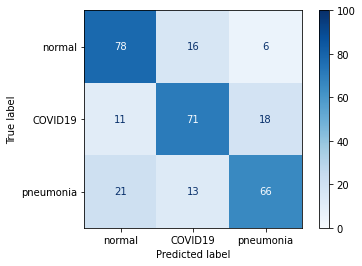

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['normal', 'COVID19', 'pneumonia']))
disp.plot(cmap='Blues') 
disp.ax_.get_images()[0].set_clim(0, 100)